In [1]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures
import scipy.signal

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load the model

butane_yaml = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/chem_annotated.yaml'
# butane_yaml = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml'
gas = ct.Solution(butane_yaml)

In [6]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 5]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 0.5

phi = table7['phi'].values.astype(float)[0]
print(phi)

x_diluent = 0.7771
conc_dict = {
    'O2(2)': 0.207,
    'butane(1)': 0.01595
}


for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

0.5


1.492537313432836 0.015935761029458245


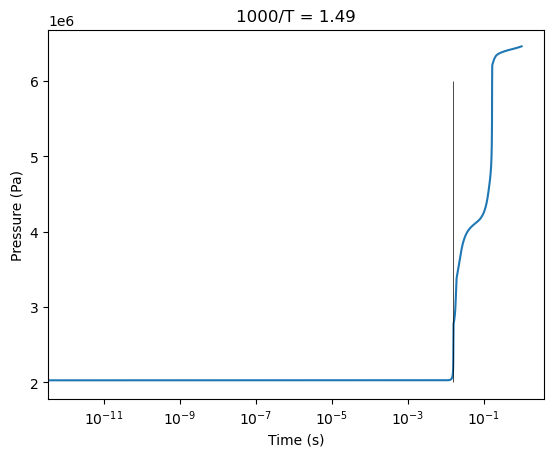

In [20]:
# atols = [1e-15, 1e-15, 1e-18]
# rtols = [1e-9, 1e-12, 1e-15]
gas = ct.Solution(butane_yaml)
t_end = 1.0  # time in seconds
# Ts = [1000]
Ts = [900]
Ts = [750]
Ts = [700]
Ts = [670]
delays = np.zeros(len(Ts))
for j, T in enumerate(Ts):
    P = P7[0]
    X = concentrations[0]
    # function to run a RCM simulation
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    
    reactor_net.atol = 1e-18
    reactor_net.rtol = 1e-15

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    plt.plot(times, P)
    
    threshold = np.percentile(slopes, 80)
    # get 1st time it goes above this threshold
#     spike_times = np.argwhere(slopes > threshold)

    
#     i = spike_times[0, 0]
    i = np.argmax(slopes)
#     plt.vlines(times[i], 2e6, 6e6, color='black')
#     delays[j] = times[i]
    print(1000 / Ts[j], times[i])
    plt.vlines(times[i], 2e6, 6e6, color='black', linewidth=0.5)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (Pa)')
    plt.title(f'1000/T = {np.round(1000 / Ts[j], 2)}')



In [ ]:
# if it's 2-stage ignition, there should be two narrow peaks here

In [ ]:
threshold = np.percentile(slopes, 80)
plt.plot(np.array(times)[np.where(slopes > threshold)[0]], slopes[np.where(slopes > threshold)[0]])
ax = plt.gca()
xlim = ax.get_xlim()

In [ ]:

scipy.signal.find_peaks()

In [ ]:
plt.plot(times, P)
# plt.xlim(xlim)

In [ ]:
times

In [ ]:
slopes_sorted = np.sort(slopes)

In [ ]:
plt.plot(slopes_sorted)

In [ ]:
plt.plot(times, P)

In [ ]:
slopes = np.gradient(P, times)
slopes_sorted = np.sort(slopes)

threshold = np.percentile(slopes, 95)
# get 1st time it goes above this threshold
spike_times = np.argwhere(slopes > threshold)

# print(spike_times)

print(times[spike_times[0, 0]])

In [ ]:
slopes_sorted[-10:]

In [ ]:
len(np.gradient(P, times))

In [ ]:
plt.plot(times, slopes)

In [ ]:
# get the 95th percentile slope value:
np.percentile(slopes, 95)


In [ ]:
plt.plot(slopes_sorted)

In [ ]:
# Look at distribution of top 10 slopes




In [ ]:
plt.hist(slopes)

In [ ]:
Ts

In [ ]:
# plot the ignition delay
plt.plot(1000.0 / np.array(Ts), delays, marker='o', label='Run 4')

# plt.plot(1000.0 / temperatures, base_delays, marker='o', label='Run 4 base')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
# plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.legend(bbox_to_anchor=(1, 1))